# Real-time Fraud Detection using Neptune ML Inductive Inference 

In this notebook we are going to show how to perform real-time fraud detection using Neptune ML. 

[Neptune ML](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning.html#machine-learning-overview) is a feature of Amazon Neptune that enables users to automate the creation, management, and usage of Graph Neural Network (GNN) machine learning models using the graph data stored in Amazon Neptune.  Neptune ML is built using [Amazon SageMaker](https://aws.amazon.com/sagemaker/) and [Deep Graph Library](https://www.dgl.ai/) and provides a simple and easy-to-use mechanism to build/train/maintain these models and then use the predictive capabilities of these models within a Gremlin query to predict elements or property values in the graph. 

For this notebook we are going to see how we can build a real-time fraud detection solution using **real-time inductive inference** and a common graph machine learning task known as **node classification**. 

With the release of Neptune version 1.2.0.2, [Neptune ML supports real-time inductive inference](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-overview.html#inductive-vs-transductive-inference), which applies data processing and model evaluation in real-time on new data that were added to the graph after the machine learning (ML) model training process. Node classification is a machine learning task where a model is learned to predict a property of the nodes in a graph.  Specifically, nodes where the property are observed are used as training examples to learn a model that can then predict that property for other nodes in the graph.  Here, the property we're trying to predict is whether or not the node is an instance of fraud. While many ML approaches can be used to tackle this problem, the GNN models of Neptune ML are unique because they use both the graph structure and the other node properties to make predictions. Traditionally, non-graph methods like XGBoost do not use graph structure and therefore do not get benefits from relationships with known-fraud, and non-GNN graph methods like Label Propagation only use graph structure and do not use node properties, so cannot benefit from other information we have about the entities in the graph (e.g., credit card country). 

Neptune ML uses a four-step process to automate the process of creating production ready GNN models:

1. **Load Data** - Data is loaded into a Neptune cluster using any of the normal methods such as the Gremlin drivers or using the Neptune Bulk Loader.
2. **Export Data** - A service call is made specifying the machine learning model type and model configuration parameters.  The data and model configuration parameters are then exported from a Neptune cluster to an S3 bucket.
3. **Model Training** - A set of service calls are made to pre-process the exported data, train the machine learning model, and then generate an Amazon SageMaker endpoint that exposes the model.
4. **Run Queries** - The final step is to use this inference endpoint within our Gremlin queries to infer data using the machine learning model.

The diagram below shows the Neptune ML workflow. The steps of data processing, model training, and endpoint creation are all handled by Neptune ML for the customer.

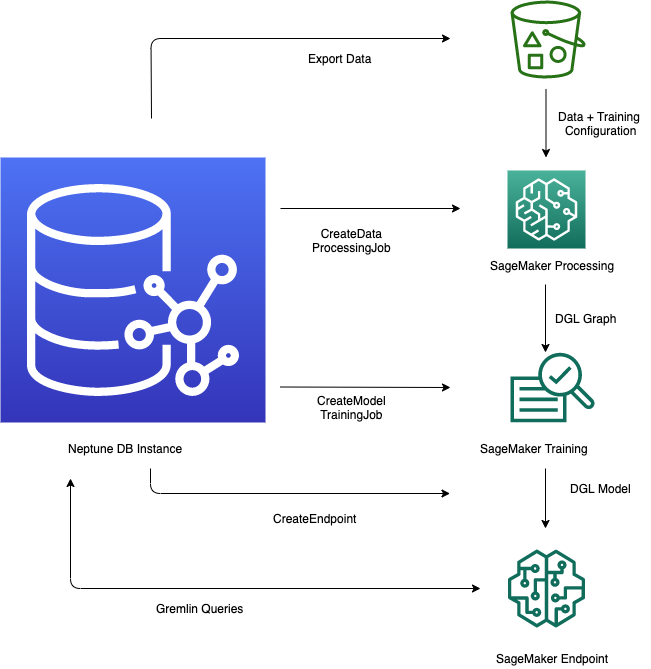


In [ ]:
!pip install sklearn umap-learn matplotlib

## The dataset

This notebook demonstrates how to use Neptune ML to perform fraud detection using the IEEE CIS dataset (https://www.kaggle.com/c/ieee-fraud-detection/data). The dataset contains Transaction and Identity tables, both having transaction ID as the primary key column. The tables have many anonymized columns, defining the relationships of the transaction records with cards, devices, products and other identifiers as shown by the figure below. 

The transaction table has a binary column indicating wheather a transaction is fraudulent. There are about 20000 transactions that are labelled as fraudulent and around 570000 transactions that are labelled as not fraudulent. 

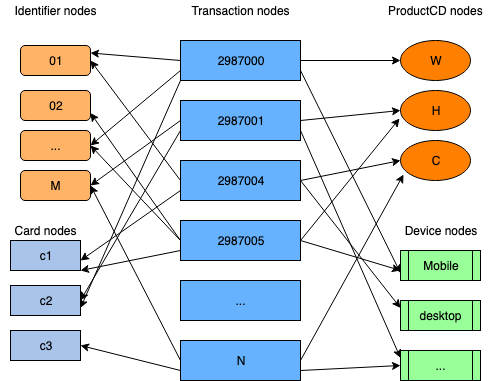

## Loading the data from S3

In this notebook, we load the graph data from a S3 bucket containing the csv files that are the results of converting the IEEE-CIS dataset to the graph data that can be stored in Amazon Neptune.

Import the ML utility and check if ML is enabled.

In [ ]:
import neptune_ml_utils as neptune_ml
neptune_ml.check_ml_enabled()

Prior to loading the data, we need to upload the files in CSV format to a S3 in the same region as the cluster. Then we can use the %load line magic to call Neptune bulk loader to load the data into Npetune.

In [ ]:
%load -s s3://neptuneml-data/ieee-cis/ -f csv -p OVERSUBSCRIBE --run

## The fraud graph data model

The graph data model contains 7 types of nodes, and 3 types of edges.

Nodes:
- Transaction
- Identifier
- Device
- Card
- Address
- Email
- Product

Edges:
- identified_by: Transaction -> Identifier
- associated_with: Transaction -> Device
- purchased_by: Transaction -> Card

The following graph shows how a transaction is connected with device, card and identifier nodes via the three types of edges.

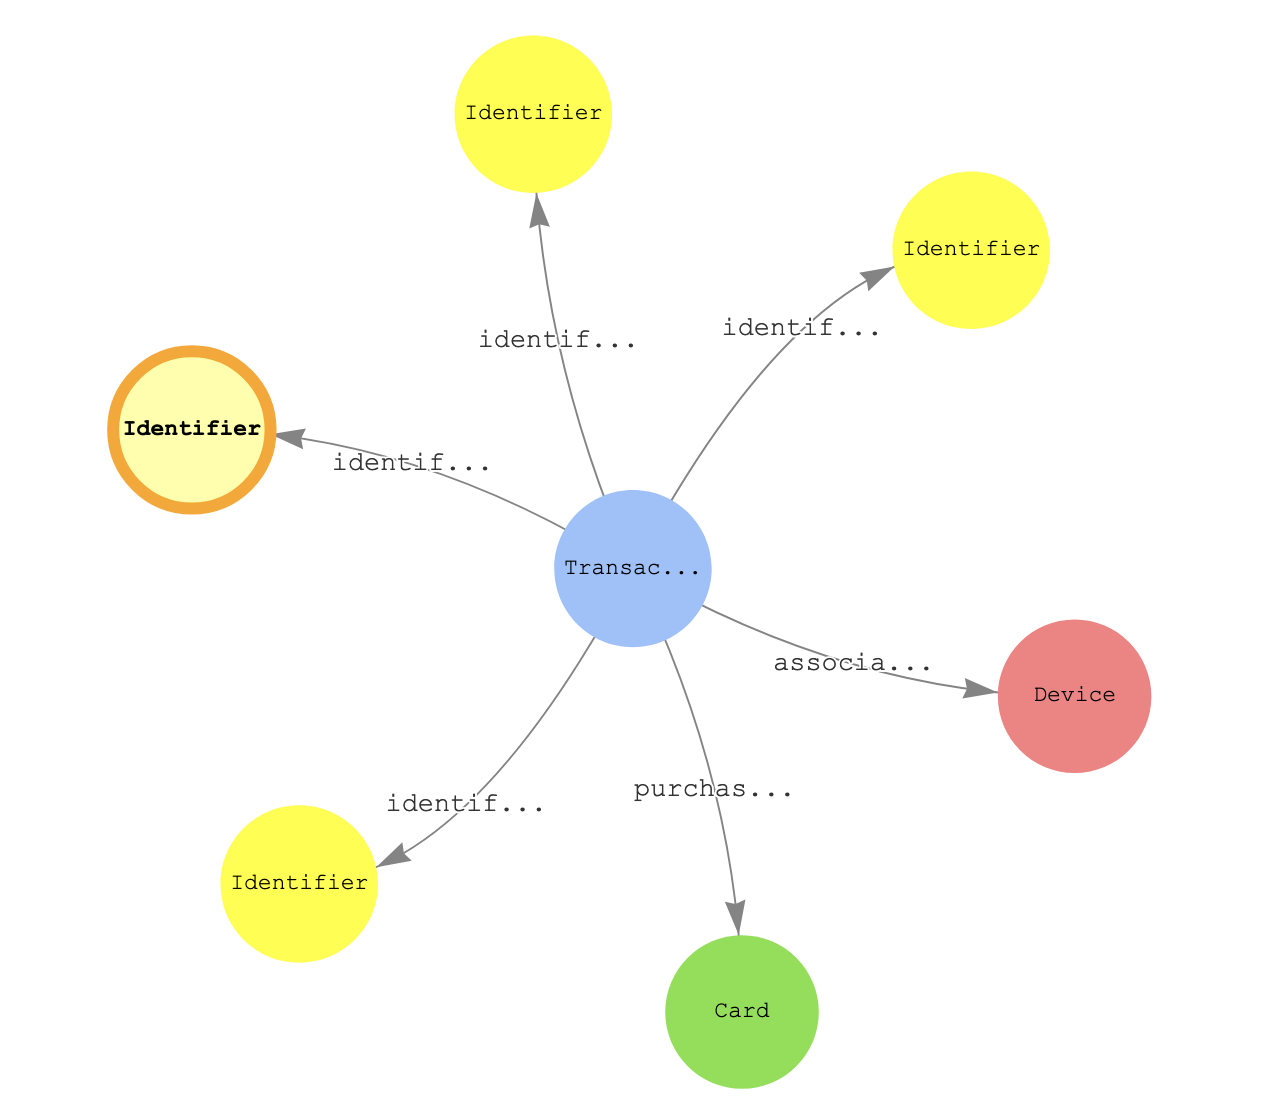

List the types and numbers of the nodes.

In [ ]:
%%gremlin
g.V().groupCount().by(label).unfold()

The output should contain:
- 590540 transactions
- 14286 cards
- 119193 identifiers
- 1788 devices

List the types numbers of the edges.

In [ ]:
%%gremlin
g.E().groupCount().by(label).unfold()

The output should contain:
- 140810 associated_with edges
- 498803 identified_by edges
- 408962 purchased_by edges

## Preparing data for Neptune ML

We save the actual values of `isFraud` as a different property so that we can compare the predicted values with the actual values.

In [ ]:
%%gremlin
g.V().hasLabel('Transaction').has('isFraud', "0").limit(1000).property('actualIsFraud', "0").iterate()

In [ ]:
%%gremlin
g.V().hasLabel('Transaction').has('isFraud', "1").limit(1000).property('actualIsFraud', "1").iterate()

Now we drop the `isFraud` property of those nodes which has `actualIsFraud` property.

In [ ]:
%%gremlin
g.V().hasLabel('Transaction').has('actualIsFraud').properties('isFraud').drop()

The following query checks if some transactions do not have the property `isFraud`. 

In [ ]:
%%gremlin
g.V().hasLabel('Transaction').hasNot('isFraud').count()

The result should be 2000. 

## Data export           

First we must set the S3 bucket for storing the model training artifacts.

In [ ]:
s3_bucket_uri="<s3-bucket-for-model-training-artifacts>"
# remove trailing slashes
s3_bucket_uri = s3_bucket_uri[:-1] if s3_bucket_uri.endswith('/') else s3_bucket_uri

The first step is to export the data to S3 using Neptune export service. Running the cell below we set the export configuration and run the export process. Neptune export is capable of automatically creating a clone of the cluster by setting cloneCluster=True which takes about 20 minutes to complete and will incur additional costs while the cloned cluster is running. Exporting from the existing cluster takes about 5 minutes but requires that the neptune_query_timeout parameter in the parameter group is set to a large enough value (>72000) to prevent timeout errors. Optionally, the parameters nodeLabels and edgeLabels can be used here to explicitly include the nodes and edges to be exported.

In [ ]:
export_params={ 
"command": "export-pg", 
"params": { "endpoint": neptune_ml.get_host(),
            "profile": "neptune_ml",
            "useIamAuth": neptune_ml.get_iam(),
            "cloneCluster": True,
            "cloneClusterInstanceType": "r5.12xlarge",
            "nodeLabels": ["Card", "Product", "Transaction", "Identifier",  "Device", "Address", "Email"],
            "edgeLabels": ["identified_by", "purchased_by", "associated_with"] 
            }, 
"outputS3Path": f'{s3_bucket_uri}/neptune-export',
"additionalParams": {
        "neptune_ml": {
          "version": "v2.0",
          "targets": [
            {
              "node": "Transaction",
              "property": "isFraud",
              "type": "classification"
            }
          ]
        }
      },
"jobSize": "medium"}

In [ ]:
%%neptune_ml export start --export-url {neptune_ml.get_export_service_host()} --export-iam --wait --store-to export_results
${export_params}

## Using Neptune ML
### Data processing

In [ ]:
# The training_job_name can be set to a unique value, otherwise one will be auto generated
training_job_name = neptune_ml.get_training_job_name('node-classification')
outputS3Uri = export_results['outputS3Uri']

In [ ]:
processing_params = f"""
--config-file-name training-data-configuration.json
--job-id {training_job_name} 
--s3-input-uri {outputS3Uri} 
--s3-processed-uri {str(s3_bucket_uri)}/preloading """

In [ ]:
%neptune_ml dataprocessing start --wait --store-to processing_results {processing_params}

### Model training

In [ ]:
training_params=f"""
--job-id {training_job_name} 
--data-processing-id {training_job_name}
--instance-type ml.p3.2xlarge
--s3-output-uri {str(s3_bucket_uri)}/training 
--max-hpo-number 2
--max-hpo-parallel 2 """

In [ ]:
%neptune_ml training start --wait --store-to training_results {training_params}

### Endpoint creation

In [ ]:
endpoint_params=f"""
--id {training_job_name}
--model-training-job-id {training_job_name}"""

In [ ]:
%neptune_ml endpoint create --wait --store-to endpoint_results {endpoint_params}

Once this has completed we get the endpoint name for our newly created inference endpoint. The cell below will set the endpoint name which will be used in the Gremlin queries below. 

In [ ]:
endpoint=endpoint_results['endpoint']['name']

## Making predictions

Depending on the nature of the business use case, you can make different types of predictions with the Neptune ML model endpoint. If you want to make predictions on data that was already present in the graph at the time of training, but whose property was unknown, then the transductive inference queries are fast and efficient, since the predictions can be precomputed at the end of training.  On the other hand, if your graph is dynamic, and you want to make predictions on new data added to the graph after the training process or see how new data affects the model prediction for an existing node then real-time inductive inference is the best choice.

### Transductive inference

During the training process, Neptune ML pre-computes and stores a model prediction for every node in the graph, which can then be looked up quickly when queried.  This is referred to as "transductive inference", and it requires that the nodes being queried for prediction were in the graph at the time of model training.  

The following query looks at the `isFraud` property of one particular transaction. As you see we do not have this property for the transaction. 

In [ ]:
%%gremlin --store-to transductive_id --silent

g.V().hasLabel('Transaction').hasNot('isFraud').limit(1).id()

In [ ]:
%%gremlin 

g.V(${transductive_id}).properties("isFraud")


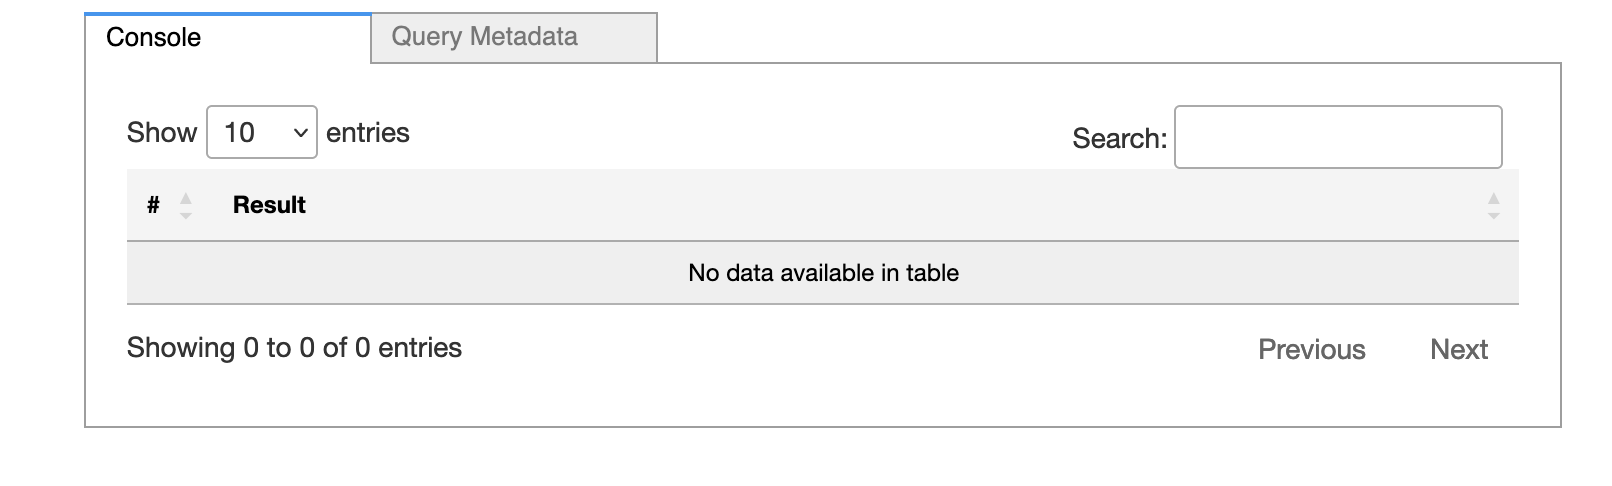

This indicates that the `isFraud` property is missing. Since this transaction was present in the graph at training time, transductive inference can be used to predict the missing property. To do that, we add two steps in the Gremlin query: 

- specify the inference endpoint that we want to use, 
- specify the type of ML task.

To the previous query, we add two with() steps to specify the inference endpoint and node classification as the ML task. Running the following query will return the predicted value (either 0 or 1) of the “isFraud” property for that transaction. It will also return the prediction probability assigned to the predicted label because of the inclusion of `Neptune#ml.score`. 

In [ ]:
%%gremlin

g.with("Neptune#ml.endpoint", "${endpoint}")
    .V(${transductive_id}).properties('isFraud', 'Neptune#ml.score')
    .with("Neptune#ml.classification")
    .value()

Next we are going to run a query to compare the predicted value with the actual value that we saved in the property `actualIsFraud`.

In [ ]:
%%gremlin

g.with("Neptune#ml.endpoint", "${endpoint}")
    .V(${transductive_id}).project('actualFraud', 'predictedFraud')
    .by(values('actualIsFraud').fold())
    .by(properties('isFraud')
    .with("Neptune#ml.transductiveInference")
    .with("Neptune#ml.classification").value().fold())

The output of the above query is as follows. In this case, the predicted value is the same as the actual value. 

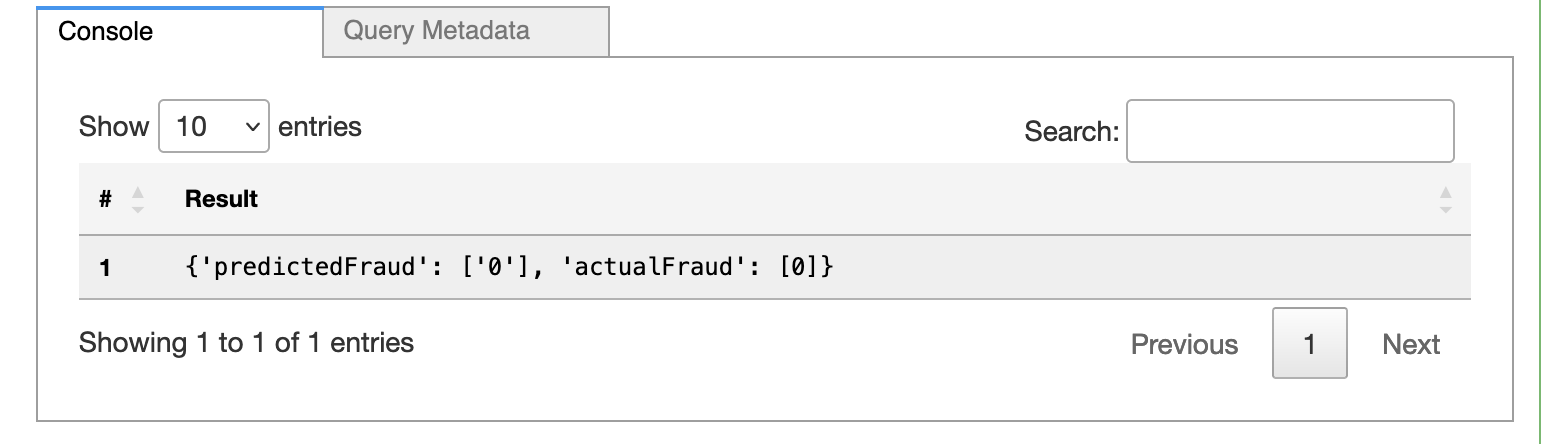

### Performance evaluation

Instead of just looking at one particular transaction, we are going to look for all transactions where `isFraud` property is missing, predict the property values, and then compare with the actual values saved in the another property. Note that we save the predicted values in `predictions`. 

In [ ]:
%%gremlin --store-to predictions

g.with("Neptune#ml.endpoint", "${endpoint}")
    .V().hasLabel('Transaction').hasNot('isFraud').project('actualFraud', 'predictedFraud')
    .by(values('actualIsFraud').fold())
    .by(properties('isFraud').with("Neptune#ml.classification").value().fold())

The following is sample python code that calculates the overall accuracy of the predictions, as well as the precentages of the correctly predicted legit and fraudulent transactions, respectively. 

In [ ]:
import pandas as pd
results = dict()
for idx, p in enumerate(predictions):
    if len(p['predictedFraud']) > 0 :
        results[idx] = {
            'predicted': int(p['predictedFraud'][0]),
            'actual': int(p['actualFraud'][0]) if p['actualFraud'] else None
        }
df_results = pd.DataFrame.from_dict(results, orient='index').dropna()

In [ ]:
acc = df_results.groupby('actual').apply(lambda x: (x['actual']==x['predicted']).mean())

In [ ]:
print(f"overall accuracy = {(df_results['actual']==df_results['predicted']).mean()*100:.1f}%")
print(f"correctly predicted legit = {acc.loc[0]*100:.1f}%")
print(f"correctly predicted fraud = {acc.loc[1]*100:.1f}%")

The results should look something like below although the numbers will be different due to the randomization of the model training process.

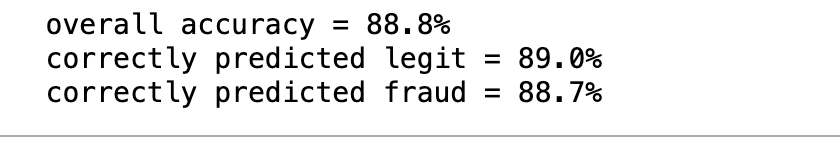

### Visualization of the embeddings

In [ ]:
transaction_mapping = neptune_ml.get_node_to_idx_mapping(dataprocessing_job_name=training_job_name,
                                                         vertex_label="Transaction")

In [ ]:
embeddings = neptune_ml.get_embeddings(training_job_name=training_job_name)

In [ ]:
predictions = neptune_ml.get_predictions(training_job_name=training_job_name, class_preds=False)

Visualization of the node embeddings showing clearly the separation of the classes.

In [ ]:
from umap import UMAP
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

dim_reducer= UMAP(n_components=2)

fig, ax = plt.subplots()
fig.suptitle("2D representation of node embeddings")

fraud_indices = np.nonzero(np.argmax(predictions, axis=1))
non_fraud_indices = np.nonzero(np.argmin(predictions, axis=1))

scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], s=1, cmap='bwr', c=np.argmax(predictions, axis=1))

plt.legend(*scatter.legend_elements(), title="isFraud", loc="upper right")

plt.grid()
plt.show()

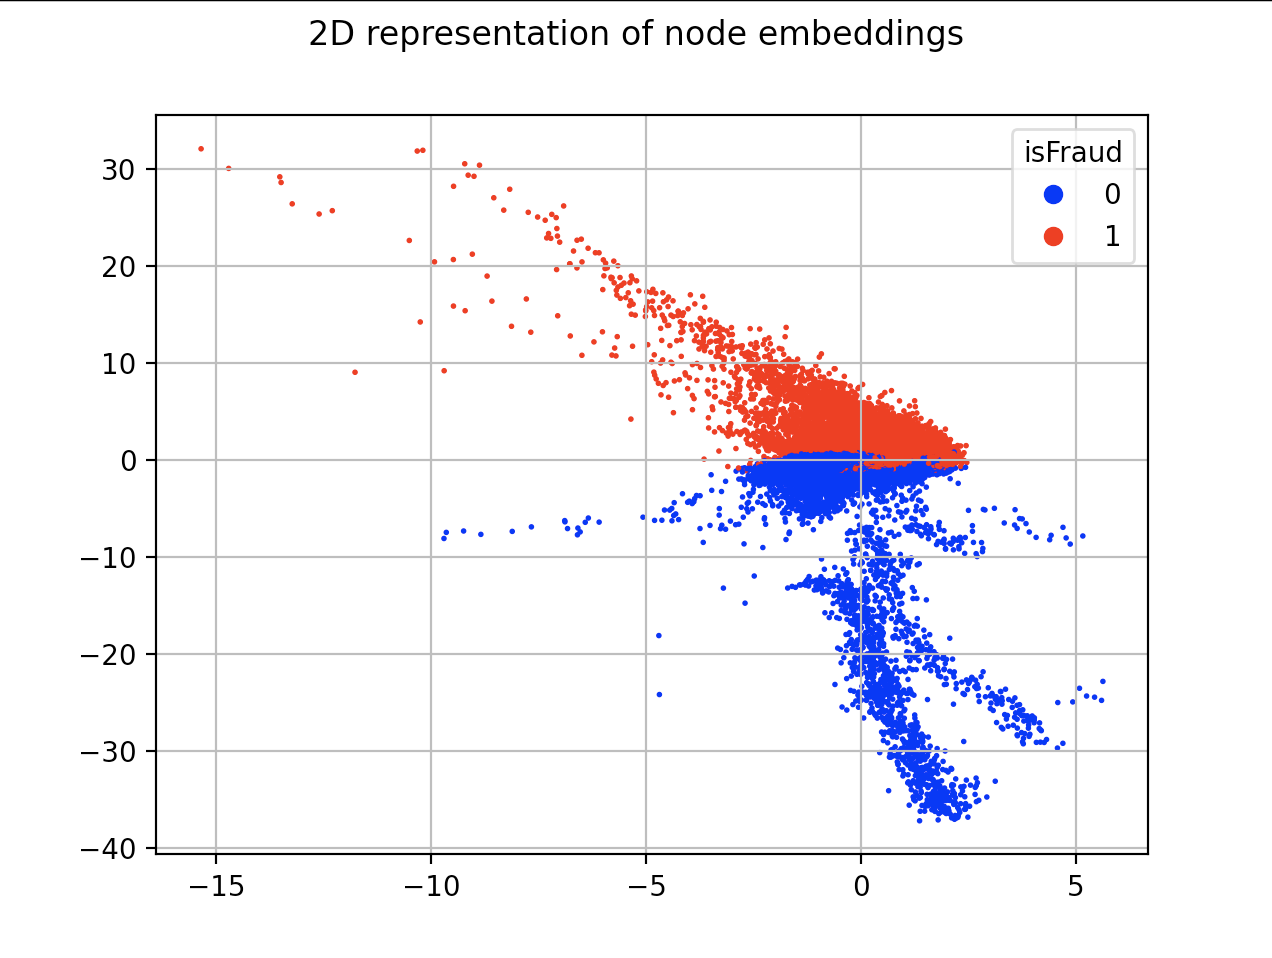

## Inductive Inference 

In a real-time application, you must make predictions on new data as it is added to the database. Specifically, in the context of the IEEE-CIS dataset, a new transaction node with edges connecting existing or new nodes may be added. The question is: how likely is it that this new transaction is a fraudulent transaction? Inductive inference can be used here. 

In inductive inference mode, GNN models use the current state of the graph to make predictions, and can therefore make predictions for new nodes and edges added after the training process. 

To demonstrate that, we are going to run a query that inserts a new node and a number of edges, and then use the model to make a prediction. First let's drop the node we are going to add in case it is already created.

In [ ]:
%%gremlin
g.V('9999999').drop()

The new transaction may be connected to existing nodes or to new nodes. For the purpose of demonstration, we assume that the transaction connects to a new device. 

First let's create a new device.

In [ ]:
%%gremlin
g.V('DeviceType:cell').drop()

In [ ]:
%%gremlin
g.addV('Device').property(T.id, 'DeviceType:cell')

If the cluster is enabled with Real-time Inductive Inference, then you can use a Gremlin query to obtain the predicted value of the “isFraud” property of the new transaction. The Gremlin query must:
- specify the inference endpoint that we want to use.
- specify the type of ML task. 
- specify the type of inference, which is “inductiveInference”. If the type isn’t specified, then the default is transductive inference. For a new node, no result of inference will be returned. 
- specify the type of sampling in the case of inductive inference, which can be either “deterministic” or “nondeterministic”. When using inductive inference, the Neptune engine creates the appropriate subgraph to evaluate the trained GNN model, and the requirements of this subgraph depend on the parameters of the final model.  By default, an inductive inference query builds the neighborhood randomly. When you include Neptune#ml.deterministic in an inductive inference query, the Neptune engine attempts to sample neighbors in a deterministic way so that running the same query returns the same results.

We run the following query that combines both mutation and inference steps. The query first adds the new transaction node and the edges connecting the new transaction to the other nodes, including the new device node. Then it executes the inductive inference step. This query may take a couple of seconds to execute.

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint",'${endpoint}')
.addV('Transaction').property(T.id, '9999999')
               .property('id_01', -5.0).property('id_02', 222578.0).property('id_05', 0.0)
               .property('id_06', 0.0).property('id_07', 0.0).property('id_11', 100.0)
               .property('id_12', 'NotFound').property('id_13', 49.0)
               .property('id_14', -300.0).property('id_15', 'New').property('id_16', 'NotFound').as('newT')
  .V('DeviceType:cell').as('deviceNode').addE('associated_with').from('newT').to('deviceNode')
  .property(T.id, 'transaction_9999999-associated-with-mobile')
  .V('card3:150.0').as('cardNode')           
  .addE('purchased_by').from('newT').to('cardNode').property(T.id, 'transaction_9999999-purchased-by-card')
  .V('id_05:0.0').as('idNode5') 
  .addE('identified_by').from('newT').to('idNode5').property(T.id, 'transaction_9999999-identified-by-id_05')
  .V('id_38:F').as('idNode38') 
  .addE('identified_by').from('newT').to('idNode38').property(T.id, 'transaction_9999999-identified-by-id_38')
  .V('9999999').properties('isFraud', "Neptune#ml.score")
  .with("Neptune#ml.classification")
  .with("Neptune#ml.inductiveInference")
  .with("Neptune#ml.deterministic").value()

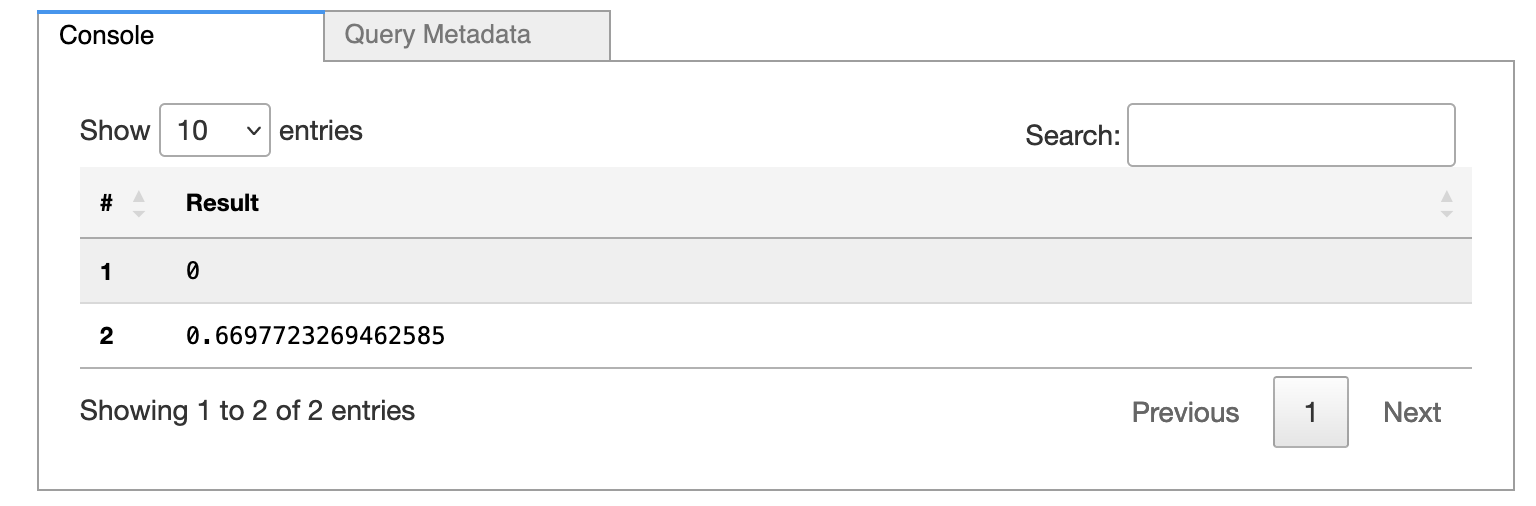

The result of the query returns both a value ("0") and a confidence score, indicating that, given the new nodes and edges being created, the ML model does not predict the new transaction to be fraudulent.

You can change the type of sampling to “nondeterministic”.

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint",'${endpoint}')           
  .V('9999999').properties("isFraud", "Neptune#ml.score")
  .with("Neptune#ml.classification")
  .with("Neptune#ml.inductiveInference")
  .with("Neptune#ml.nondeterministic")
  .value()

## Clean up 
Now that you have completed this walkthrough you have created a Sagemaker endpoint which is currently running and will incur the standard charges.  If you are done trying out Neptune ML and would like to avoid these recurring costs, run the cell below to delete the inference endpoint.

In [ ]:
neptune_ml.delete_endpoint(training_job_name)